In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image as kimage
import tensorflow.keras.backend as K

In [2]:
%matplotlib widget

In [3]:
def preprocess(img, path=False):

    if path:
        x = kimage.load_img(img, target_size=(224, 224))
    else:
        x = img
        
    x = kimage.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    return x


def depreprocess(x):

    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]

    return np.clip((t + [123.68, 116.779, 103.939]), 0, 255) / 255


def predict_file(model, img_path):
    img = kimage.load_img(img_path, target_size=(224, 224))

    '''
    plt.imshow(img)
    plt.grid('off')
    plt.axis('off')
    '''
    
    x = preprocess(img)
    
    preds = model.predict(x)
    return preds

def save_image(x, path, fmt=None):
    x = depreprocess(x)
    kimage.array_to_img(x)
    kimage.save_img(path, x, file_format=fmt)
    
def process_noise(x):
    """
    RGB images have positive valued pixels, but computing the 
    difference of two images can produce negative values as well
    
    This function constructs a positive valued bitmap from image differences
    by substiting negative values with their complementary color and adding
    it on top. Complements are just the combination of the other two coor channels
    """
    
    color_add = np.clip(x, 0, np.inf)
    color_sub = np.clip(x, -np.inf, 0) @ (np.eye(3) - 1)
    return color_add + color_sub

In [4]:
def untargeted_ifgsm(model, x, initial_class, epochs=25, epsilon=.1):
    x_adv = x
    x_noise = np.zeros_like(x)
    target = K.one_hot(initial_class, model.output_shape[1])
    
    for i in range(epochs):
        # Get the loss and gradient of the loss wrt the inputs
        x_tens = tf.Variable(x_adv)
        with tf.GradientTape() as gtape:
            y = model(x_tens)
            loss = K.categorical_crossentropy(target, tf.reshape(y, (-1, )))
            
        # Get the sign of the gradient
        grads = gtape.gradient(loss, x_tens)
        delta = K.sign(grads[0])
        
        # Perturb the image
        x_adv = x_adv + epsilon * delta

        # Get the new image and predictions
        preds = model.predict(x_adv)

        # Yield the adversarial example and the predictions of the model
        yield (i, x_adv, preds[0])

In [5]:
def targeted_ifgsm(model, x, target_class, epochs=25, epsilon=.1):
    x_adv = x
    target = K.one_hot(target_class, model.output_shape[1])
    
    for i in range(epochs):
        # Get the loss and gradient of the loss wrt the inputs
        x_tens = tf.Variable(x_adv)
        with tf.GradientTape() as tape:
            y = model(x_tens)
            loss = -1 * K.categorical_crossentropy(target, tf.reshape(y, (-1, )))

        # Get the sign of the gradient
        # print(x_tens[0])
        grads = tape.gradient(loss, x_tens)
        delta = K.sign(grads[0])
        # Perturb the image
        x_adv = x_adv + epsilon * delta
        # Get the new image and predictions
        preds = model.predict(x_adv)

        # Yield the adversarial example and the predictions of the model
        yield (i, x_adv, preds[0])

In [10]:
orig = preprocess("flamingo.jpeg", True)
plt.imshow(depreprocess(orig))

In [1]:
model = resnet50.ResNet50(weights='imagenet')
pred = model.predict(orig)
resnet50.decode_predictions(pred)

NameError: name 'resnet50' is not defined

In [8]:
initial_class = np.argmax(pred)
print('Original prediction:', pred[0, initial_class])

results = []
for i, adv, p in untargeted_ifgsm(model, orig, initial_class, epochs=100, epsilon=.01):
    results.append((adv, p))
    
    if i % 10 == 0:
        print(p[initial_class])
        
    if p[initial_class] < .0001:
        break

Original prediction: 0.9980323
0.9974572
0.97319794
0.8089074
0.39261255
0.10768649
0.025453925
0.006303286
0.001666143
0.00043267084
0.00011510001


[[('n01443537', 'goldfish', 0.99966896),
  ('n02007558', 'flamingo', 8.4037034e-05),
  ('n01514668', 'cock', 2.823707e-05),
  ('n09256479', 'coral_reef', 2.1583195e-05),
  ('n02607072', 'anemone_fish', 1.8273091e-05)]]

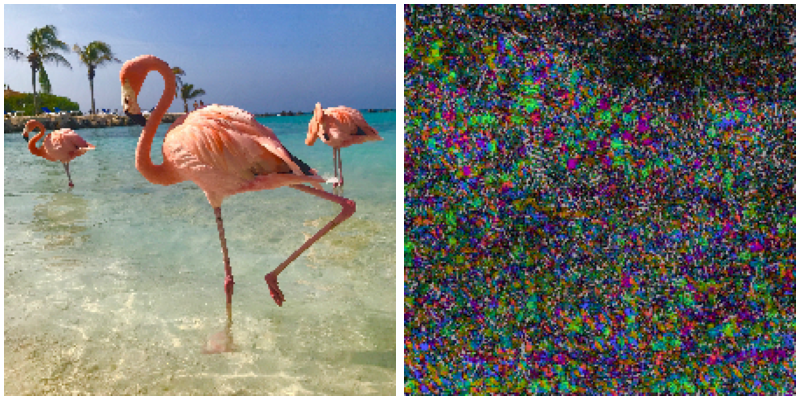

In [32]:
adv, p = results[-1]

plt.close('all')
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax0.imshow(depreprocess(adv))
dx = process_noise((adv - orig).numpy().squeeze())
ax1.imshow(dx / dx.max())

for ax in (ax0, ax1):
    ax.grid('off')
    ax.axis('off')
    
resnet50.decode_predictions(p.reshape(1, -1))

In [13]:
target_class = 1
z = np.zeros((1, 1000))
z[0, target_class] = 1
print(resnet50.decode_predictions(z, top=1))
initial_class = np.argmax(pred)

print('Original'.ljust(20), 'Target')

results = []
for i, adv, p in targeted_ifgsm(model, orig, target_class, epsilon=.1):
    results.append((adv, p))
    
    if i % 1 == 0:
        print(f'{p[initial_class]:<20.10} {p[target_class]:.10}')
        
    if p[initial_class] < .0001 and p[target_class] > .5:
        break

[[('n01443537', 'goldfish', 1.0)]]
Original             Target
0.9861580133         1.382548453e-05
0.9273692966         0.0001264720922
0.7545611262         0.0007769621443
0.5589097738         0.003022074234
0.4666889012         0.01022695284
0.4023934305         0.03245723248
0.3608380556         0.0975337401
0.2936068475         0.2501862049
0.1883954555         0.4955131114
0.09170100838        0.7565535903
0.03212536871        0.9090138674
0.01136526931        0.9681226015
0.002951125382       0.98996979
0.001049061422       0.9967381358
0.0002714436268      0.9989797473
9.73363567e-05       0.9996777773


[[('n01443537', 'goldfish', 0.99966896),
  ('n02007558', 'flamingo', 8.4037034e-05),
  ('n01514668', 'cock', 2.823707e-05),
  ('n09256479', 'coral_reef', 2.1583195e-05),
  ('n02607072', 'anemone_fish', 1.8273091e-05)]]

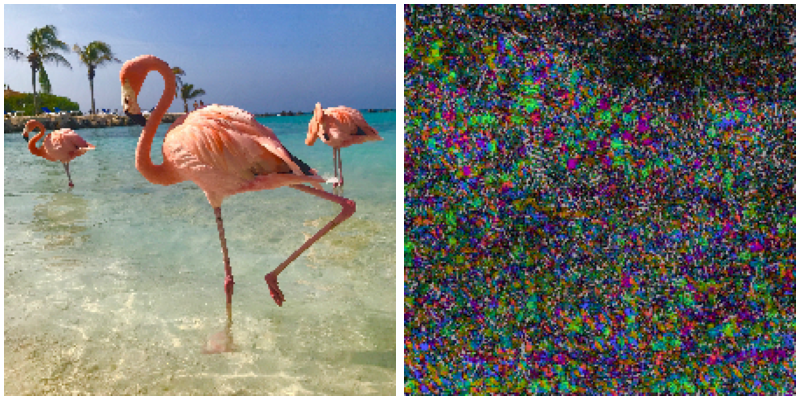

In [35]:
adv, p = results[-1]

# %matplotlib widget
plt.close('all')
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax0.imshow(depreprocess(adv))
dx = process_noise((adv - orig).numpy().squeeze())
ax1.imshow(dx / dx.max())

for ax in (ax0, ax1):
    ax.grid('off')
    ax.axis('off')
    
resnet50.decode_predictions(p.reshape(1, -1))

In [36]:
# Attack will be affected by discretization and compression
for fmt in ['bmp', 'png', 'jpeg']:
    save_image(adv, f'adversarial.{fmt}', fmt=fmt)
    p = predict_file(model, f'adversarial.{fmt}')
    
    print(fmt, resnet50.decode_predictions(p))

bmp [[('n01443537', 'goldfish', 0.99942553), ('n02007558', 'flamingo', 0.00015705841), ('n01514668', 'cock', 4.2293213e-05), ('n09256479', 'coral_reef', 4.1142495e-05), ('n02607072', 'anemone_fish', 2.742604e-05)]]
png [[('n01443537', 'goldfish', 0.99942553), ('n02007558', 'flamingo', 0.00015705841), ('n01514668', 'cock', 4.2293213e-05), ('n09256479', 'coral_reef', 4.1142495e-05), ('n02607072', 'anemone_fish', 2.742604e-05)]]
jpeg [[('n02007558', 'flamingo', 0.8345057), ('n09428293', 'seashore', 0.026766278), ('n09421951', 'sandbar', 0.017980115), ('n01983481', 'American_lobster', 0.008816934), ('n02837789', 'bikini', 0.008135647)]]
